In [ ]:
# How to naviagate this notebook.
# First I have defined UU dagger circuit.
# Then two dataset has been collected and processed. I also collected metrics for UU dagger in between.
# m_data,m_labels and h_data, h_labels are two the datsets. h_data= Medquad. m_data= Medical Transcription.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install ctgan

In [ ]:
%pip install table_evaluator

In [ ]:
%pip install pylatexenc

In [ ]:
import pylatexenc

In [ ]:
%pip install qiskit
%pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 41.9 MB/s eta 0:00:00


In [ ]:
%pip install qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.4/35.4 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.12.0
    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0
 

In [ ]:
%pip install qiskit-algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
import qiskit
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from qiskit import QuantumCircuit

In [ ]:
from ctgan import CTGAN

In [ ]:
from qiskit_aer import AerSimulator
# @title UUDagger circuit
def U_circuit(qc,theta):
  qc.u(theta[0],0,0,0)
  qc.cu(theta[1],0,0,0,0,1)
  qc.x(0)
  qc.cu(theta[2],0,0,0,0,1)
  qc.x(0)

  qc.mcx([0, 1], 3)
  qc.cu(theta[3],0,0,0,3,2)
  qc.mcx([0, 1], 3)

  qc.x(0)
  qc.mcx([0, 1], 3)
  qc.cu(theta[4],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)

  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(theta[5],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(1)

  qc.x(0)
  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(theta[6],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)
  qc.x(1)
  return qc

def U_circuit_rev(qc,theta):
  qc.x(0)
  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(-theta[6],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)
  qc.x(1)

  qc.x(1)
  qc.mcx([0, 1], 3)
  qc.cu(-theta[5],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(1)

  qc.x(0)
  qc.mcx([0, 1], 3)
  qc.cu(-theta[4],0,0,0,3,2)
  qc.mcx([0, 1], 3)
  qc.x(0)

  qc.mcx([0, 1], 3)
  qc.cu(-theta[3],0,0,0,3,2)
  qc.mcx([0, 1], 3)

  qc.x(0)
  qc.cu(-theta[2],0,0,0,0,1)
  qc.x(0)

  qc.cu(-theta[1],0,0,0,0,1)

  qc.u(-theta[0],0,0,0)

  return qc

# Datasets

## MedQUAD (HCD)

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
import os
# os.chdir('QML')
#Hyperparameter
max_length=51
import pandas as pd
df = pd.read_csv(r'/content/drive/MyDrive/LLM Healthcare/medquad.csv', usecols=['question', 'focus_area'])
arr=df.to_numpy()
# Label count and index
label_count={}
for i in arr:
  label_count[i[-1]]=label_count.get(i[-1],0)+1
labels_count=sorted(label_count.items(),key=lambda x:-x[1])
label_index={i[0]:j for j,i in enumerate(labels_count)}
#Word count and index
word_counts={}
for i in arr:
  for j in i[0].split():
    word_counts[j]=word_counts.get(j,0)+1
word_counts=sorted(word_counts.items(),key=lambda x:-x[1])
word_index={i[0]:j+1 for j,i in enumerate(word_counts)}
word_index['PAD']=0
word_index=dict(sorted(word_index.items(),key=lambda x:x[1]))
#Tokenization
def tokenization(words):
  token=[]
  for i in words:
    k=[]
    for j in i.split():
      k.append(word_index[j])
    token.append(k)
  return token
# Tokenizing the data
tokenized_data=tokenization([i[0] for i in arr])
labels=[label_index[i[1]] for i in arr]
#Padding the data
data= keras.preprocessing.sequence.pad_sequences(tokenized_data,maxlen=max_length,padding="post")
#Only selecting two labels
new_data,label=[],[]
for i,j in zip(data,labels):
  if j<2:
    new_data.append(i)
    label.append(j)
combined_data=pd.DataFrame(np.c_[new_data,label])
h_data=new_data
h_label= label
combined_data.columns = list(combined_data.columns)[:-1] + ['Cluster']

In [ ]:
combined_data

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,Cluster
0,2,5,6,117,33,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,44,5,42,43,7,117,101,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,3,4,10,8,117,33,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,3,4,11,7,117,33,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,3,4,11,7,117,33,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,13,12,56,117,33,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
92,44,5,42,43,7,117,101,1,0,0,...,0,0,0,0,0,0,0,0,0,1
93,34,36,38,39,40,5,37,35,7,117,...,0,0,0,0,0,0,0,0,0,1
94,2,5,6,111,33,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
cluster = np.array(df['Cluster'])
cluster

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0])

In [ ]:
df = combined_data

In [ ]:
numeric_cols = df.select_dtypes(include=np.number).columns

all_zero_cols = [col for col in numeric_cols if df[col].sum() == 0]

df_cleaned = df.drop(columns=all_zero_cols)

In [ ]:
df = df_cleaned

In [ ]:
# Convert each row to a NumPy array
row_arrays = []
for index, row in df.iterrows():
    row_arrays.append(row.to_numpy())

In [ ]:
h_data = row_arrays

In [ ]:
h_data

[array([  2,   5,   6, 117,  33,   1,   0,   0,   0,   0,   0,   0,   1]),
 array([ 44,   5,  42,  43,   7, 117, 101,   1,   0,   0,   0,   0,   1]),
 array([  2,   3,   4,  10,   8, 117,  33,   1,   0,   0,   0,   0,   1]),
 array([  2,   3,   4,  11,   7, 117,  33,   1,   0,   0,   0,   0,   1]),
 array([  2,   3,   4,  11,   7, 117,  33,   1,   0,   0,   0,   0,   1]),
 array([ 34,  36,  38,  39,  40,   5,  37,  35,   7, 117,  33,   1,   1]),
 array([  2,   5,   6, 117,  33,   1,   0,   0,   0,   0,   0,   0,   1]),
 array([  2,   5,   6, 117,  33,   1,   0,   0,   0,   0,   0,   0,   1]),
 array([ 13,  18,  17,   3,  19,  16, 117,  33,   1,   0,   0,   0,   1]),
 array([  2,   5,   6, 117,  33,   1,   0,   0,   0,   0,   0,   0,   1]),
 array([  2,  27, 117,  33,   1,   0,   0,   0,   0,   0,   0,   0,   1]),
 array([ 44,   5,  42,  43,   7, 117, 101,   1,   0,   0,   0,   0,   1]),
 array([ 44,   5,  42,  43,   7, 117, 101,   1,   0,   0,   0,   0,   1]),
 array([ 44,   5,  42,  4

In [ ]:
df_cleaned

,0,1,2,3,4,5,6,7,8,9,10,11,Cluster
0,2,5,6,117,33,1,0,0,0,0,0,0,1
1,44,5,42,43,7,117,101,1,0,0,0,0,1
2,2,3,4,10,8,117,33,1,0,0,0,0,1
3,2,3,4,11,7,117,33,1,0,0,0,0,1
4,2,3,4,11,7,117,33,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,13,12,56,117,33,1,0,0,0,0,0,0,1
92,44,5,42,43,7,117,101,1,0,0,0,0,1
93,34,36,38,39,40,5,37,35,7,117,33,1,1
94,2,5,6,111,33,1,0,0,0,0,0,0,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit import QuantumCircuit,transpile
from qiskit.visualization import plot_histogram
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, TwoLocal

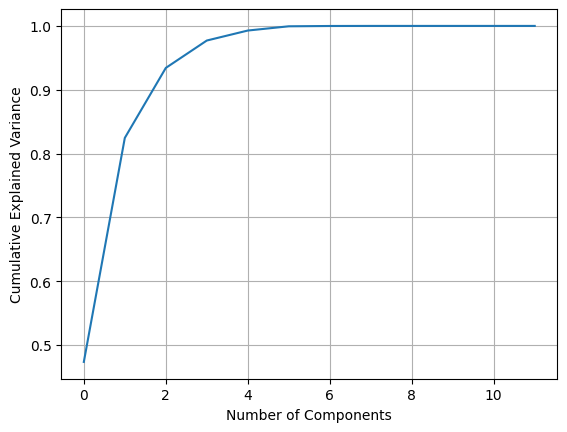

Accuracy: 0.7000 ± 0.0000
Precision: 0.4900 ± 0.0000
Recall: 0.7000 ± 0.0000
F1-score: 0.5765 ± 0.0000


In [ ]:
N=4
num_data_points=50
test_size=0.2

zeros_string = '0' * N
Num_shots=1024

#num_components=0
#for i in range(N):
#  num_components+=2**i

#df_sampled = combined_data.sample(n=num_data_points, random_state=42)

#df_sampled = df_cleaned.sample(n=num_data_points, random_state=42)
df_sampled = df.sample(n=num_data_points, replace=True, random_state=42)


# Extract features and labels
X = df_sampled.drop('Cluster', axis=1)  # Assuming 'Cluster' is the target variable
y = df_sampled['Cluster']
#Minmax transform
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
#PCA transform
#pca = PCA(n_components=num_components)
n_components = min(X_scaled.shape[0], X_scaled.shape[1])
pca = PCA(n_components=n_components)

pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

num_clusters=2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(df_pca)

centroids = kmeans.cluster_centers_

# Print centroid 0 and centroid 1
centroid_0 = centroids[0]
centroid_1 = centroids[1]

# Add the cluster labels to the DataFramez
df_pca['Cluster'] = labels

A = df_pca.drop('Cluster', axis=1)  # Assuming 'Cluster' is the target variable
B = df_pca['Cluster']

from sklearn.model_selection import StratifiedKFold
from qiskit_aer import AerSimulator

def run_qsvm(X, y, centroids, N, Num_shots=1024):
    zeros_string = '0' * N
    predicted_labels = []

    for i in range(len(X)):
        x = X.iloc[i].values

        qc1 = QuantumCircuit(N+1, N)

        #change
        ansatz = TwoLocal(N+1, reps=14, entanglement='linear')
        param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=ansatz.num_parameters)
        #print(param_values)
        ansatz.assign_parameters(param_values, inplace=True)
        qc1.compose(ansatz.decompose(), inplace=True)

        featuremap = ZZFeatureMap(N+1, reps=35, entanglement='linear')
        param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=featuremap.num_parameters)
        #print(param_values)
        featuremap.assign_parameters(param_values, inplace=True)
        qc1.compose(featuremap.decompose(), inplace=True)


        #ansatz = RealAmplitudes(N+1, reps=3, entanglement='linear')
        #param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=ansatz.num_parameters)
        #print(param_values)
        #ansatz.assign_parameters(param_values, inplace=True)
        #qc1.compose(ansatz.decompose(), inplace=True)
        #change

        qc1 = U_circuit(qc1, x)
        qc1 = U_circuit_rev(qc1, centroids[0])
        qc1.measure(range(N), range(N))
        backend = AerSimulator(method='automatic')
        result1 = backend.run(qc1, shots=Num_shots).result()
        p0_qc1 = result1.get_counts(0).get(zeros_string, 0) / Num_shots

        #qc2
        qc2 = QuantumCircuit(N+1, N)
        qc2 = U_circuit(qc2, x)
        qc2 = U_circuit_rev(qc2, centroids[1])
        qc2.measure(range(N), range(N))
        result2 = backend.run(qc2, shots=Num_shots).result()
        p0_qc2 = result2.get_counts(0).get(zeros_string, 0) / Num_shots

        predicted_labels.append(0 if p0_qc1 > p0_qc2 else 1)

    return predicted_labels

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
import numpy as np

# 10-Fold CV
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True)

accuracies = []
precisions = []
recalls = []
f1s = []

for train_index, test_index in skf.split(A, B):
    X_train, X_test = A.iloc[train_index], A.iloc[test_index]
    y_train, y_test = B.iloc[train_index], B.iloc[test_index]

    # Recalculate centroids for this fold
    kmeans = KMeans(n_clusters=num_clusters, )
    kmeans.fit(X_train)
    fold_centroids = kmeans.cluster_centers_

    y_pred = run_qsvm(X_test, y_test, fold_centroids, N)

    # Collect metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1s.append(f1_score(y_test, y_pred, average='weighted'))

# Print results

print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

In [ ]:
accuracies

[0.8, 0.6, 0.8, 0.8, 0.8, 0.6, 0.6, 0.6, 0.6, 0.6]

In [ ]:
precisions

[0.64, 0.6, 0.64, 0.64, 0.64, 0.36, 0.36, 0.36, 0.36, 0.36]

In [ ]:
recalls

[0.8, 0.6, 0.8, 0.8, 0.8, 0.6, 0.6, 0.6, 0.6, 0.6]

In [ ]:
f1s

[0.711111111111111,
 0.6,
 0.711111111111111,
 0.711111111111111,
 0.711111111111111,
 0.45,
 0.45,
 0.45,
 0.45,
 0.45]

In [ ]:
y_pred = run_qsvm(A, B, centroids, N)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"Accuracy: {accuracy_score(B, y_pred):.4f}")
print(f"Precision: {precision_score(B, y_pred, average='weighted', zero_division=0):.4f}")
print(f"Recall: {recall_score(B, y_pred, average='weighted'):.4f}")
print(f"F1-score: {f1_score(B, y_pred, average='weighted'):.4f}")

Accuracy: 0.7000
Precision: 0.4900
Recall: 0.7000
F1-score: 0.5765


In [ ]:
accuracies

[0.6923076923076923, 0.6923076923076923, 0.75, 0.6666666666666666]

##  Medical Transcription Dataset

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras

# Step 1: Load the data
df = pd.read_csv(r'/content/drive/MyDrive/LLM Healthcare/mtsamples.csv', header=None)  # Add `names=` if needed
text_col = df.iloc[:, 4]  # 4th column (0-indexed)
# Step 2: Classify based on diabetes mention
yes_texts = []
no_texts = []

for text in text_col.dropna():
    if 'diabetes' in text.lower():
        if len(yes_texts) < 100:
            yes_texts.append(text)
    else:
        if len(no_texts) < 100:
            no_texts.append(text)
    if len(yes_texts) >= 100 and len(no_texts) >= 100:
        break

texts = yes_texts + no_texts
labels = [1] * 100 + [0] * 100  # 1 for diabetes, 0 for not
# Step 3: Build vocabulary
word_counts = {}
for sentence in texts:
    for word in sentence.split():
        word_counts[word] = word_counts.get(word, 0) + 1

# Sort and index
word_counts = sorted(word_counts.items(), key=lambda x: -x[1])
word_index = {word: i+1 for i, (word, _) in enumerate(word_counts)}
word_index['PAD'] = 0
word_index = dict(sorted(word_index.items(), key=lambda x: x[1]))

# Step 4: Tokenization
def tokenize(sentences):
    tokenized = []
    for sentence in sentences:
        tokenized.append([word_index.get(word, 0) for word in sentence.split()])
    return tokenized

tokenized_data = tokenize(texts)

# Step 5: Padding
max_length = 51
padded_data = keras.preprocessing.sequence.pad_sequences(tokenized_data, maxlen=max_length, padding='post')

# Step 6: Final dataset
final_data = pd.DataFrame(np.c_[padded_data, labels])
m_data = padded_data
m_label = labels

In [ ]:
final_data

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,4454,2645,4455,936,2646,2647,249,4456,699,3287,...,806,3291,39,514,6833,4465,6834,39,1651,1
1,1313,56,4487,19,43,338,5,663,5,56,...,10,1655,72,43,6906,186,12,2657,6907,1
2,43,1109,1,240,2670,1476,2222,267,2670,1318,...,1,11,5,1109,6,4518,561,194,3323,1
3,11,10,215,3330,12,666,18,30,1666,68,...,38,22,882,5,284,186,9,6,1111,1
4,4605,1484,2676,19,13,51,135,9,30,4606,...,2688,1906,1316,12,2689,62,43,34,2688,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,9,1572,2404,6760,7,1262,4,1,81,202,...,1,243,628,7,11,178,1,96,199,0
196,3,60,8,170,455,461,2636,88,315,1293,...,208,12,6,1035,4,1,239,9,14185,0
197,2,1855,901,15,60,8,182,276,88,2,...,20,65,5,1,243,102,9,111,238,0
198,455,1967,841,79,1414,3,40,14,92,4326,...,9,135,760,394,1623,5,1,243,628,0


In [ ]:
m_data

array([[4454, 2645, 4455, ..., 6834,   39, 1651],
       [1313,   56, 4487, ...,   12, 2657, 6907],
       [  43, 1109,    1, ...,  561,  194, 3323],
       ...,
       [   2, 1855,  901, ...,    9,  111,  238],
       [ 455, 1967,  841, ...,    1,  243,  628],
       [   1,   81,  202, ...,    9,  135,  238]], dtype=int32)

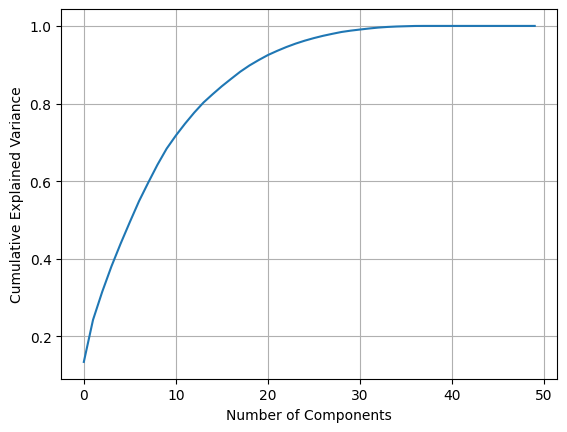

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Accuracy: 0.9200 ± 0.1600
Precision: 0.9543 ± 0.0914
Recall: 0.9200 ± 0.1600
F1-score: 0.9350 ± 0.1300


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from qiskit.transpiler import generate_preset_pass_manager

N =4
num_data_points = 50
test_size = 0.2

zeros_string = '0' * N
Num_shots = 1024

num_components = 0
for i in range(N):
    num_components += 2 ** i

# Use final_data where last column is the label
df_sampled = final_data.sample(n=num_data_points, replace=True, random_state=42)

# Extract features and labels
X = df_sampled.iloc[:, :-1]  # All columns except the last one
y = df_sampled.iloc[:, -1]   # The last column as label

# MinMax transform
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# PCA transform
#pca = PCA(n_components=num_components)
n_components = min(X_scaled.shape[0], X_scaled.shape[1])
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(df_pca)

centroids = kmeans.cluster_centers_

# Print centroid 0 and centroid 1
centroid_0 = centroids[0]
centroid_1 = centroids[1]

# Add the cluster labels to the DataFrame
df_pca['Cluster'] = labels

A = df_pca.drop('Cluster', axis=1)
B = df_pca['Cluster']

from sklearn.model_selection import StratifiedKFold
from qiskit_aer import AerSimulator

def run_qsvm(X, y, centroids, N, Num_shots=124):
    zeros_string = '0' * N
    predicted_labels = []

    for i in range(len(X)):
        x = X.iloc[i].values

        qc1 = QuantumCircuit(N+1, N)

        ansatz = ZZFeatureMap(N+1, reps=15, entanglement='linear')
        param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=ansatz.num_parameters)
        #print(param_values)
        ansatz.assign_parameters(param_values, inplace=True)
        qc1.compose(ansatz.decompose(), inplace=True)

        ansatz = TwoLocal(N+1, reps=45, entanglement='linear')
        param_values = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=ansatz.num_parameters)
        #print(param_values)
        ansatz.assign_parameters(param_values, inplace=True)
        qc1.compose(ansatz.decompose(), inplace=True)

        qc1 = U_circuit(qc1, x)
        qc1 = U_circuit_rev(qc1, centroids[0])
        qc1.measure(range(N), range(N))
        backend = AerSimulator(method='automatic')

        # Transpile the circuit
        #pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
        #transpiled_qc1 = pass_manager.run(qc1)
        result1 = backend.run(qc1, shots=Num_shots).result()
        p0_qc1 = result1.get_counts(0).get(zeros_string, 0) / Num_shots

        qc2 = QuantumCircuit(N+1, N)
        qc2 = U_circuit(qc2, x)
        qc2 = U_circuit_rev(qc2, centroids[1])
        qc2.measure(range(N), range(N))
        # Transpile the circuit
        #pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)
        #transpiled_qc2 = pass_manager.run(qc2)
        result2 = backend.run(qc2, shots=Num_shots).result()
        p0_qc2 = result2.get_counts(0).get(zeros_string, 0) / Num_shots

        predicted_labels.append(0 if p0_qc1 > p0_qc2 else 1)

    return predicted_labels

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
import numpy as np

# 5-Fold CV
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True)

accuracies = []
precisions = []
recalls = []
f1s = []

for train_index, test_index in skf.split(A, B):
    X_train, X_test = A.iloc[train_index], A.iloc[test_index]
    y_train, y_test = B.iloc[train_index], B.iloc[test_index]

    # Recalculate centroids for this fold
    kmeans = KMeans(n_clusters=num_clusters,)
    kmeans.fit(X_train)
    fold_centroids = kmeans.cluster_centers_

    y_pred = run_qsvm(X_test, y_test, fold_centroids, N)

    # Collect metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    recalls.append(recall_score(y_test, y_pred, average='weighted'))
    f1s.append(f1_score(y_test, y_pred, average='weighted'))

# Print results
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1-score: {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")


#Class Metrics

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris

# Assuming m_data and m_label are already defined
X, y = m_data, m_label

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define models in a dictionary
models = {
    'SVC': make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale')),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
}

# Metrics to evaluate
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Evaluate each model
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print(f"\n{name}:")
    print(f"  Accuracy : {scores['test_accuracy'].mean():.4f} ± {scores['test_accuracy'].std():.4f}")
    print(f"  Precision: {scores['test_precision_weighted'].mean():.4f} ± {scores['test_precision_weighted'].std():.4f}")
    print(f"  Recall   : {scores['test_recall_weighted'].mean():.4f} ± {scores['test_recall_weighted'].std():.4f}")
    print(f"  F1-score : {scores['test_f1_weighted'].mean():.4f} ± {scores['test_f1_weighted'].std():.4f}")



SVC:
  Accuracy : 0.6900 ± 0.0889
  Precision: 0.7057 ± 0.0914
  Recall   : 0.6900 ± 0.0889
  F1-score : 0.6825 ± 0.0934

Random Forest:
  Accuracy : 0.7700 ± 0.0557
  Precision: 0.7919 ± 0.0581
  Recall   : 0.7700 ± 0.0557
  F1-score : 0.7653 ± 0.0596

KNN:
  Accuracy : 0.4750 ± 0.1101
  Precision: 0.4734 ± 0.1170
  Recall   : 0.4750 ± 0.1101
  F1-score : 0.4640 ± 0.1111

Logistic Regression:
  Accuracy : 0.5950 ± 0.0522
  Precision: 0.6032 ± 0.0567
  Recall   : 0.5950 ± 0.0522
  F1-score : 0.5882 ± 0.0539


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_iris

# Assuming m_data and m_label are already defined
X, y = h_data, h_label

# Cross-validation setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define models in a dictionary
models = {
    'SVC': make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale')),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5)),
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
}

# Metrics to evaluate
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# Evaluate each model
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring)
    print(f"\n{name}:")
    print(f"  Accuracy : {scores['test_accuracy'].mean():.4f} ± {scores['test_accuracy'].std():.4f}")
    print(f"  Precision: {scores['test_precision_weighted'].mean():.4f} ± {scores['test_precision_weighted'].std():.4f}")
    print(f"  Recall   : {scores['test_recall_weighted'].mean():.4f} ± {scores['test_recall_weighted'].std():.4f}")
    print(f"  F1-score : {scores['test_f1_weighted'].mean():.4f} ± {scores['test_f1_weighted'].std():.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


SVC:
  Accuracy : 0.4889 ± 0.0715
  Precision: 0.3038 ± 0.0630
  Recall   : 0.4889 ± 0.0715
  F1-score : 0.3715 ± 0.0593

Random Forest:
  Accuracy : 0.9800 ± 0.0600
  Precision: 0.9857 ± 0.0429
  Recall   : 0.9800 ± 0.0600
  F1-score : 0.9792 ± 0.0625

KNN:
  Accuracy : 0.8633 ± 0.1077
  Precision: 0.9029 ± 0.0654
  Recall   : 0.8633 ± 0.1077
  F1-score : 0.8527 ± 0.1240

Logistic Regression:
  Accuracy : 0.4489 ± 0.1075
  Precision: 0.3989 ± 0.2091
  Recall   : 0.4489 ± 0.1075
  F1-score : 0.3853 ± 0.1122
